In [1]:
#IPython extension to reload modules before executing user code. If we make any change in function 
# and imoprting it we don't need to restart if we use auto reload 
%load_ext autoreload

# to print in between values as well without print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


#hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle


# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.metrics import classification_report
from pprint import pprint as pp


# scipy
from scipy.stats import boxcox

# yellowbrick
from yellowbrick.classifier import ROCAUC

# Supporting Functions

In [3]:
# to save pickle file
def save_pkl_model(path,model):
    pickle.dump(model, open(path,'wb'))

In [4]:
# to load
def load_pkl_model(path):
    sc = pickle.load(open(path,'rb'))
    return sc

In [46]:
def preprocess_pipeline_1(test):
   
    # miss_num_imputer = load_pkl_model(missing_num_imputer_path)
    # missing_cat_imputer = load_pkl_model(missing_cat_imputer_path)
    ohe_converter = load_pkl_model(ohe_converter_path)
    num_transformer = load_pkl_model(mms_converter_path)

    # processing numeric
    num_cols = test.select_dtypes(include='number')
    num_column_names = num_cols.columns
    # num_miss_processed = miss_num_imputer.transform(num_cols)
    num_scalled = num_transformer.transform(num_cols)
    num_scalled_df = pd.DataFrame(num_scalled,columns=num_column_names)


    # processing categoric
    cat_cols = test.select_dtypes(include='O')
    # cat_miss_processed = missing_cat_imputer.transform(cat_cols)
    cat_encoded = ohe_converter.transform(cat_cols).toarray()
    cat_encoded_df = pd.DataFrame(cat_encoded,columns=ohe_converter.get_feature_names_out())


    # combine categoric and numeric data and return
    test_processed = pd.concat([num_scalled_df,cat_encoded_df],axis=1)
    
    return test_processed

In [51]:
def func_dropCol(df):
    for i in column_elimination:
        df = df[df.columns.drop(list(df.filter(regex=i)))]
    return df

# Test and Analysis

## Load and Predict

In [135]:
# spacify saved preprocessing model paths
# missing_num_imputer_path = 'Data/processing_models/imputer_num.pkl'
# missing_cat_imputer_path = 'Data/processing_models/imputer_cat.pkl'
ohe_converter_path = 'Data/processing_models/ohe_converter.pkl'
mms_converter_path = 'Data/processing_models/mms_converter.pkl'
column_elimination = ['SectionID',
                   'StageID',
                  'Semester']
# Specify final ML model path
final_model_path = 'models/xgboost.pkl'


In [43]:
# load test data and check
test_data = pd.read_csv('Data/test.csv')
test_data.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,F,Jordan,Jordan,lowerlevel,G-02,A,French,S,Mum,25,80,29,23,No,Good,Under-7,M
1,M,KW,KuwaIT,MiddleSchool,G-07,A,Math,F,Father,11,2,2,8,No,Bad,Under-7,L
2,M,KW,KuwaIT,lowerlevel,G-02,B,IT,F,Father,50,7,9,50,Yes,Bad,Above-7,M
3,M,Jordan,Jordan,MiddleSchool,G-06,A,English,F,Father,10,8,10,10,Yes,Bad,Above-7,M
4,M,Iraq,Iraq,MiddleSchool,G-06,A,English,F,Mum,74,71,56,37,No,Good,Under-7,H


In [48]:
# devide Xtest ytest to compare
X_test,y_test = test_data.loc[:,~test_data.columns.isin(['Class'])],test_data['Class']

In [49]:
# preporcess the data for the model input
X_test_processed = preprocess_pipeline_1(X_test)
X_test_processed.head()

,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_M,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,...,Topic_IT,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Semester_S,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7
0,0.25,0.808081,0.295918,0.224490,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
1,0.11,0.020202,0.020408,0.071429,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.50,0.070707,0.091837,0.500000,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.10,0.080808,0.102041,0.091837,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.74,0.717172,0.571429,0.367347,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [52]:
X_test_processed = func_dropCol(X_test_processed)

In [92]:
X_test_processed

,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_M,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,...,Topic_History,Topic_IT,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7
0,0.25,0.808081,0.295918,0.224490,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,0.11,0.020202,0.020408,0.071429,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.50,0.070707,0.091837,0.500000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.10,0.080808,0.102041,0.091837,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.74,0.717172,0.571429,0.367347,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.55,0.727273,0.846939,0.132653,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
68,0.00,0.030303,0.102041,0.020408,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,0.70,0.696970,0.357143,0.295918,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
70,0.05,0.090909,0.193878,0.989796,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
# load the final model
final_model = load_pkl_model(final_model_path)

In [137]:
# prefict the model
y_pred = final_model.predict(X_test_processed)
y_pred

array([2, 1, 1, 1, 0, 0, 2, 2, 0, 1, 0, 2, 1, 2, 1, 1, 2, 2, 0, 0, 1, 1,
       2, 0, 2, 0, 0, 1, 2, 2, 2, 0, 0, 1, 2, 0, 1, 1, 0, 2, 0, 1, 2, 0,
       1, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 1, 1, 0, 2, 1, 0, 1,
       0, 2, 1, 0, 1, 2], dtype=int64)

In [65]:
key_to_label

{0: 'H', 1: 'L', 2: 'M'}

In [71]:
l = {0 : 'H', 1 : 'L', 2 : 'M'}

In [75]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [76]:
le.fit(y_test)

LabelEncoder()

In [126]:
le.transform(y_test)

array([2, 1, 2, 2, 0, 0, 2, 0, 0, 1, 2, 2, 1, 2, 1, 1, 0, 2, 2, 0, 1, 2,
       2, 2, 2, 0, 0, 1, 2, 2, 0, 0, 0, 1, 2, 0, 1, 1, 2, 2, 0, 1, 2, 0,
       1, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 1, 0, 2, 1, 1, 2, 2, 2, 0, 1,
       2, 2, 1, 0, 1, 1])

In [138]:
le.inverse_transform(y_pred)

array(['M', 'L', 'L', 'L', 'H', 'H', 'M', 'M', 'H', 'L', 'H', 'M', 'L',
       'M', 'L', 'L', 'M', 'M', 'H', 'H', 'L', 'L', 'M', 'H', 'M', 'H',
       'H', 'L', 'M', 'M', 'M', 'H', 'H', 'L', 'M', 'H', 'L', 'L', 'H',
       'M', 'H', 'L', 'M', 'H', 'L', 'H', 'M', 'M', 'M', 'M', 'M', 'M',
       'L', 'M', 'M', 'M', 'L', 'H', 'M', 'L', 'L', 'H', 'M', 'L', 'H',
       'L', 'H', 'M', 'L', 'H', 'L', 'M'], dtype=object)

In [139]:
y_pred

array([2, 1, 1, 1, 0, 0, 2, 2, 0, 1, 0, 2, 1, 2, 1, 1, 2, 2, 0, 0, 1, 1,
       2, 0, 2, 0, 0, 1, 2, 2, 2, 0, 0, 1, 2, 0, 1, 1, 0, 2, 0, 1, 2, 0,
       1, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 1, 1, 0, 2, 1, 0, 1,
       0, 2, 1, 0, 1, 2], dtype=int64)

In [140]:
y_pred = le.inverse_transform(y_pred)

## Prediction Analysis

### a. Classification Report

In [141]:
# pp(classification_report(y_test,y_pred))
report = classification_report(y_test,y_pred,output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
H,0.714286,0.714286,0.714286,21.00
L,0.782609,0.947368,0.857143,19.00
M,0.750000,0.656250,0.700000,32.00
accuracy,0.750000,0.750000,0.750000,0.75
macro avg,0.748965,0.772635,0.757143,72.00
weighted avg,0.748188,0.750000,0.745635,72.00


### b. Confusion metrics

In [142]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test,y_pred,labels=['L','M','H'])
cm

array([[18,  1,  0],
       [ 5, 21,  6],
       [ 0,  6, 15]], dtype=int64)

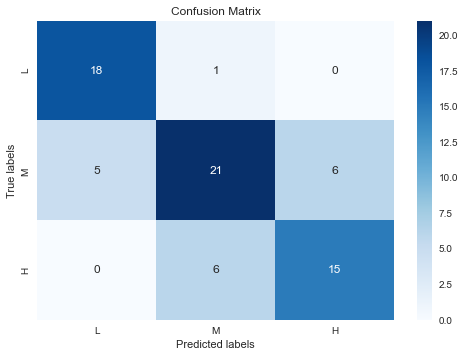

In [143]:
# sn.heatmap(cm, annot=True, cmap='Blues',xticklabels=['L','M','H'],yticklabels=['L','M','H'])

# plotting the values
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='d', ax=ax,cmap='Blues')  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['L','M','H']); ax.yaxis.set_ticklabels(['L','M','H']);

### ROC AUC curve

In [86]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model)
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

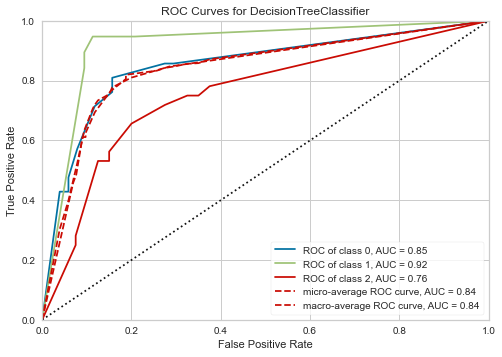

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=DecisionTreeClassifier(max_depth=10, min_samples_leaf=5))

In [87]:
plot_ROC_curve(final_model,X_train,y_train,X_test_processed,y_test)

### Save Test Results

In [144]:
test_data['predictions'] = y_pred
test_data.to_csv('test_results/test_pred_xgboost.csv',index=False)

### Analyse wrong predictions

In [145]:
test_data[test_data['Class']!=test_data['predictions']]

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class,predictions
2,M,KW,KuwaIT,lowerlevel,G-02,B,IT,F,Father,50,7,9,50,Yes,Bad,Above-7,M,L
3,M,Jordan,Jordan,MiddleSchool,G-06,A,English,F,Father,10,8,10,10,Yes,Bad,Above-7,M,L
7,M,Jordan,Jordan,lowerlevel,G-02,A,French,S,Mum,50,90,83,13,Yes,Good,Under-7,H,M
10,M,KW,KuwaIT,MiddleSchool,G-08,C,Spanish,S,Mum,57,51,46,34,Yes,Good,Under-7,M,H
16,F,lebanon,lebanon,lowerlevel,G-02,B,French,S,Mum,80,42,33,13,Yes,Bad,Under-7,H,M
18,M,Jordan,Jordan,lowerlevel,G-02,B,Arabic,F,Mum,15,90,21,97,Yes,Good,Under-7,M,H
21,M,SaudiArabia,SaudiArabia,lowerlevel,G-02,B,IT,F,Father,7,12,5,3,No,Bad,Above-7,M,L
23,F,Jordan,Jordan,MiddleSchool,G-06,A,English,F,Mum,70,64,42,32,No,Bad,Under-7,M,H
30,F,KW,KuwaIT,MiddleSchool,G-06,A,Science,S,Father,80,94,62,77,Yes,Good,Under-7,H,M
38,M,lebanon,lebanon,MiddleSchool,G-08,C,Spanish,S,Father,77,69,41,13,Yes,Good,Under-7,M,H


	Random forest 
    
    precision	recall	f1-score	support
H	0.833333	0.714286	0.769231	21.000000
L	0.760000	1.000000	0.863636	19.000000
M	0.793103	0.718750	0.754098	32.000000
accuracy	0.791667	0.791667	0.791667	0.791667
macro avg	0.795479	0.811012	0.795655	72.000000
weighted avg	0.796102	0.791667	0.787418	72.000000

svm 
	precision	recall	f1-score	support
H	0.708333	0.809524	0.755556	21.000000
L	0.761905	0.842105	0.800000	19.000000
M	0.740741	0.625000	0.677966	32.000000
accuracy	0.736111	0.736111	0.736111	0.736111
macro avg	0.736993	0.758876	0.744507	72.000000
weighted avg	0.736874	0.736111	0.732800	72.000000

array([[16,  3,  0],
       [ 5, 20,  7],
       [ 0,  4, 17]], dtype=int64)

xgboost

precision	recall	f1-score	support
H	0.714286	0.714286	0.714286	21.00
L	0.782609	0.947368	0.857143	19.00
M	0.750000	0.656250	0.700000	32.00
accuracy	0.750000	0.750000	0.750000	0.75
macro avg	0.748965	0.772635	0.757143	72.00
weighted avg	0.748188	0.750000	0.745635	72.00

array([[18,  1,  0],
       [ 5, 21,  6],
       [ 0,  6, 15]], dtype=int64)

# Final Conclution 